<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Reconhecimento de emoções em arquivos de áudio<br>a partir da extração de descritores espectrais
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

Principais atividades do notebook:
- Carregamento da base de dados
- Extração de features
- Tratamento de features
- Gravação da base da dados preparada

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>

<br>

<a id='libs'></a>

### Bibliotecas
<br>
<blockquote>
    <dl>
        <dl>- keras: interface para desenvolvimento de redes neurais.</dl>
        <dl>- librosa: múltiplas funcionalidades para tratamento de arquivos de áudio.</dl>
        <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
        <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
        <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
        <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
        <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
    </dl>
</blockquote>


In [ ]:
# ! pip install --upgrade matplotlib
# ! pip install spafe
# # docs -> https://spafe.readthedocs.io/en/latest/index.html

In [ ]:
import librosa as ls
import numpy as np 
import pandas as pd 
import IPython.display as play

from spafe.features import gfcc, mfcc, pncc

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns

import os
from tqdm import tqdm 

In [ ]:
### Set visual features to pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<br>
<a id='data'></a>

### Dados

<font size=1>[menu](#menu)</font>

Lista os caminhos de referência dos arquivos de áudio na pasta de origem para posterior leitura e extração de features.

In [ ]:
# Getting file paths
folder_path = '../data/'
dataset = 'ravdess'
files_list = []
for dirname, _, filenames in os.walk(folder_path+dataset):
    for filename in filenames:
        files_list.append(os.path.join(dirname, filename))

print(f'Total files: {len(files_list)}')

Total files: 1440


Filtra a lista de arquivos a fim de garantir que tenham formatos de áudio válidos e compatíveis à leitura da biblioteca de extração de features `librosa`.

In [ ]:
### Search just for wav or mp3 files
files_list = [file for file in files_list if  '.wav' in file or '.mp3' in file]

Cria dicionário para mapeamento das classes de sentimentos existentes na base de dados.

In [ ]:
emotions_dict = {'01' : 'neutral', 
                '02' : 'calm' ,
                '03' : 'happy' ,
                '04' : 'sad' ,
                '05' : 'angry', 
                '06' : 'fearful' ,
                '07' : 'disgust', 
                '08' : 'surprised'}

Executa seleção randômica de arquivos da base de dados e extrai informações para visualização.

In [ ]:
### Set number of samples to visualize
n_samples = 15

np.random.seed(31)
samples = []
for n in tqdm(range(n_samples)):
    random_file_idx = np.random.randint(0, len(files_list))
    audio,sfreq = ls.load(files_list[random_file_idx])
    time = np.arange(0,len(audio))/sfreq
    actor = files_list[random_file_idx].split("/")[-2]
    emotion = emotions_dict[files_list[random_file_idx].split("-")[2]]
    samples.append((emotion, actor, time, audio))


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Gera visualização dos arquivos de áudio selecionados randomicamente acima.
- Título: ator e sentimento 
- Eixo x: duração do sinal
- Eixo y: amplitude do sinal

100%|██████████| 15/15 [00:00<00:00, 201.11it/s]


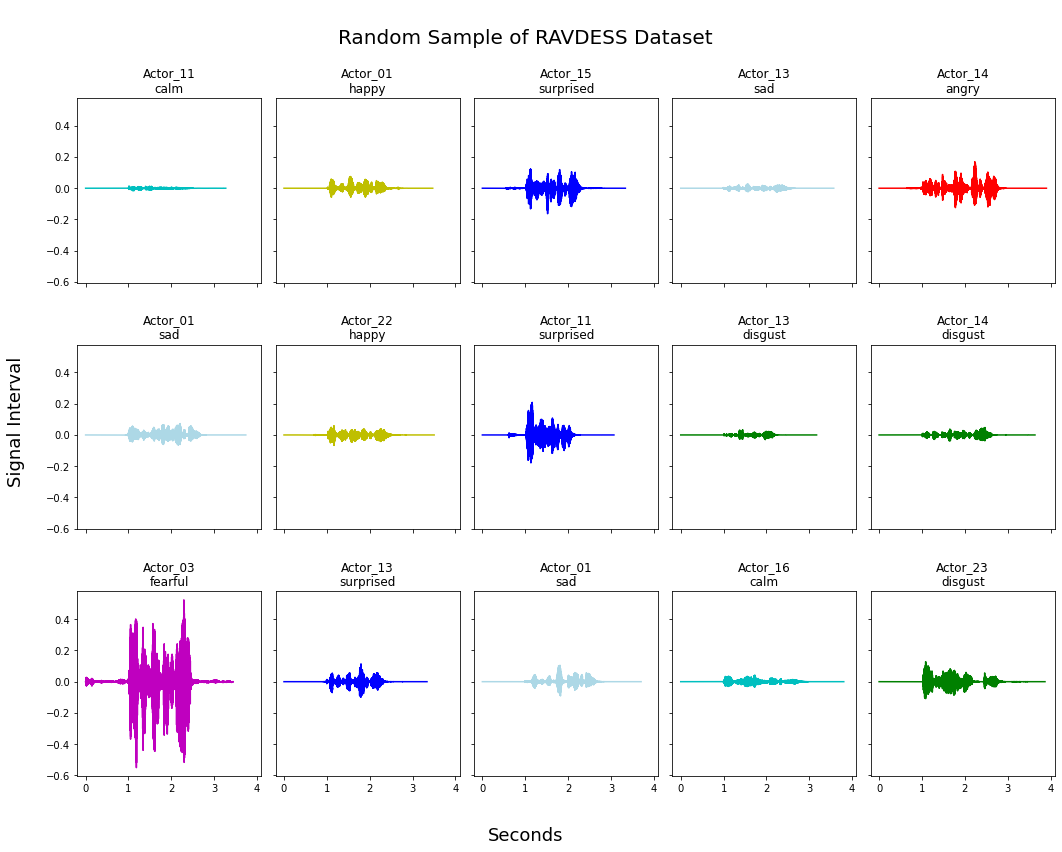

In [ ]:
### Visualize above extracted samples
### note: rows * columns result musn't
### be less than total of samples

rows = 3
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True, figsize=(rows*5,rows*4))
ax = ax.ravel()

colors_dict = {'neutral': 'w', 
                'calm':'c',
                'happy': 'y',
                'sad':'lightblue',
                'angry':'r', 
                'fearful':'m',
                'disgust':'g', 
                'surprised':'b'}

for i in tqdm(range(len(samples))):
    ax[i].plot(samples[i][2],samples[i][3], colors_dict.get(samples[i][0]))
    ax[i].set_title(f'\n{samples[i][1]}\n{samples[i][0]}')

fig.suptitle('\nRandom Sample of RAVDESS Dataset', fontsize=20)
fig.supxlabel('\nSeconds', fontsize=18)
fig.supylabel('Signal Interval\n', fontsize=18)
fig.tight_layout()

Gera audição de áudio selecionado randomicamente e exibido na vizualição acima.

In [ ]:
### Player can fail in VSCode

### Set sample
audio_sample = 0
print(f'\n{samples[audio_sample][1]}\n{samples[audio_sample][0].upper()}')
play.Audio(samples[audio_sample][3], rate=22050)


Actor_11
CALM


<br>
<a id='prep'></a>

### Pré-processamento

<font size=1>[menu](#menu)</font>

##### Extração

Método para extração de features.

In [ ]:

# Extract features from audio files
def extract_feature(file_name: str, mel=True, chroma=True, mfccs=True,
                                    gfccs=True, pnccs=True) -> np.array:
        
        result=np.array([])
        X, sample_rate = ls.load(file_name, sr=48000)

        if mel:
            mel=np.mean(ls.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if chroma:
            stft=np.abs(ls.stft(X))
            chroma=np.mean(ls.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=40).T,axis=0)
            result=np.hstack((result, chroma))
        if mfccs:
            mfccs=np.mean(ls.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if gfccs:
            gfccs=np.mean(gfcc.gfcc(X, fs=sample_rate, num_ceps=40, lifter=0,nfilts=41).T, axis=1)
            result=np.hstack((result, gfccs))
        if pnccs:
            pnccs=np.mean(pncc.pncc(X, fs=sample_rate, num_ceps=40, lifter=0,nfilts=41).T, axis=1)
            result=np.hstack((result, pnccs))
        

        return result

Extrai 

In [ ]:
### Extract features from files
### and get associated emotion

features, emotions, actors = [],[],[]

for file in tqdm(files_list):
    feature = extract_feature(file, mel=True, chroma=True, mfccs=True,
                                    gfccs=True, pnccs=True)
    emotion = emotions_dict[file.split("-")[2]]
    actor = file.split('/')[-2]

    features.append(feature)
    emotions.append(emotion)
    actors.append(actor)



100%|██████████| 1440/1440 [21:03<00:00,  1.14it/s]



- 128 feataures correspondem ao espectograma da escala mel
- 40 features correspondem ao cromagrama
- 40 features correspondem aos mfccs
- 40 features correspondem aos gfccs
- 40 features correspondem aos pnccs
- 1 feature corresponde à classe do sentimento
- 1 feature corresponde à identificação da atriz/ator


In [ ]:
features_name = ['MEL','CHROMA','MFCC','GFCC','PNCC']
features_interval = [(0,128),(128,168),(168,208),(208,248),(248,288)]

In [ ]:
### Create dataset
df = pd.DataFrame(features)
print(df.shape)
df.head(2)

(1440, 288)


0         1         2         3         4         5         6    \
0  0.000017  0.001432  0.016623  0.026257  0.015734  0.010567  0.021449   
1  0.000013  0.000555  0.009175  0.020292  0.018322  0.006961  0.013214   

        7         8         9        10        11        12        13   \
0  0.021755  0.020524  0.009863  0.00822  0.013816  0.033411  0.040123   
1  0.015581  0.016653  0.013299  0.00488  0.005009  0.009620  0.019270   

        14        15        16        17        18        19        20   \
0  0.012572  0.013553  0.034026  0.013780  0.002775  0.009250  0.014812   
1  0.014089  0.002810  0.002958  0.008433  0.005448  0.000935  0.001446   

        21        22        23        24        25        26        27   \
0  0.005438  0.000991  0.000789  0.000499  0.000236  0.000204  0.000422   
1  0.004113  0.002633  0.000371  0.000264  0.000293  0.000107  0.000083   

        28        29        30        31        32        33        34   \
0  0.000827  0.000662  0.000440  0.000311  0.001147  0.001432  0.001616   
1  0.000176  0.000178  0.000349  0.000179  0.000137  0.000242  0.000957   

        35        36        37        38        39        40        41   \
0  0.003586  0.003505  0.000857  0.000492  0.000760  0.000564  0.000585   
1  0.001207  0.000271  0.000193  0.000659  0.000289  0.000185  0.000401   

        42        43        44        45        46        47        48   \
0  0.000884  0.000715  0.000982  0.000890  0.000628  0.000447  0.000292   
1  0.000114  0.000638  0.000640  0.000149  0.000215  0.000227  0.000187   

        49        50        51        52        53        54        55   \
0  0.000514  0.001107  0.000223  0.000068  0.000124  0.000108  0.000124   
1  0.000705  0.000376  0.000076  0.000070  0.000059  0.000077  0.000101   

        56        57        58        59        60        61        62   \
0  0.000363  0.000613  0.000627  0.000435  0.000205  0.000093  0.000101   
1  0.000134  0.000137  0.000316  0.000212  0.000143  0.000063  0.000042   

        63        64        65        66        67        68        69   \
0  0.000087  0.000127  0.000178  0.000218  0.000291  0.000348  0.000403   
1  0.000015  0.000012  0.000015  0.000024  0.000035  0.000052  0.000077   

        70        71        72        73        74        75        76   \
0  0.000125  0.000042  0.000013  0.000016  0.000023  0.000040  0.000047   
1  0.000076  0.000046  0.000012  0.000006  0.000010  0.000015  0.000023   

        77       78        79        80        81        82        83   \
0  0.000064  0.00008  0.000052  0.000048  0.000026  0.000025  0.000037   
1  0.000018  0.00004  0.000034  0.000025  0.000028  0.000033  0.000050   

        84        85        86        87        88        89        90   \
0  0.000028  0.000018  0.000012  0.000008  0.000005  0.000004  0.000004   
1  0.000050  0.000039  0.000034  0.000015  0.000007  0.000006  0.000006   

        91        92        93        94        95        96        97   \
0  0.000005  0.000006  0.000004  0.000002  0.000003  0.000003  0.000003   
1  0.000006  0.000005  0.000007  0.000005  0.000003  0.000004  0.000004   

        98        99        100       101       102       103       104  \
0  0.000002  0.000002  0.000004  0.000006  0.000006  0.000005  0.000004   
1  0.000005  0.000006  0.000003  0.000004  0.000004  0.000004  0.000003   

        105       106       107       108       109       110       111  \
0  0.000003  0.000003  0.000002  0.000002  0.000002  0.000002  0.000001   
1  0.000004  0.000004  0.000002  0.000002  0.000002  0.000001  0.000001   

            112           113           114           115           116  \
0  1.236189e-06  2.178529e-06  1.341962e-06  8.759328e-07  7.719471e-07   
1  8.758655e-07  7.264676e-07  4.894324e-07  3.679957e-07  2.989512e-07   

            117           118           119           120           121  \
0  5.428048e-07  3.798515e-07  2.659118e-07  1.358990e-07  6.421450e-08   
1  1.622806e-07  1.376

In [ ]:
### Rename columns with feature type

def name_feature_type(data: pd.DataFrame, features_name: list,
                      features_interval: list) -> pd.DataFrame:
  new_names_list = []
  for idx, interval in enumerate(features_interval):
      [new_names_list.append(features_name[idx]+'_'+str(i)) for i in range(interval[1]-interval[0])];
      
  data.columns = new_names_list
  return data


df = name_feature_type(df, features_name, features_interval)

In [ ]:
### Add emotion and actor info to dataset
df = pd.concat([df, pd.DataFrame({'emotion':emotions, 'actor':actors})], axis=1)
print(df.shape)
df.head(3)

(1440, 290)


MEL_0     MEL_1     MEL_2     MEL_3     MEL_4     MEL_5     MEL_6  \
0  0.000017  0.001432  0.016623  0.026257  0.015734  0.010567  0.021449   
1  0.000013  0.000555  0.009175  0.020292  0.018322  0.006961  0.013214   
2  0.000022  0.001418  0.016818  0.038978  0.025689  0.008387  0.020807   

      MEL_7     MEL_8     MEL_9    MEL_10    MEL_11    MEL_12    MEL_13  \
0  0.021755  0.020524  0.009863  0.008220  0.013816  0.033411  0.040123   
1  0.015581  0.016653  0.013299  0.004880  0.005009  0.009620  0.019270   
2  0.037611  0.032856  0.008531  0.007175  0.018059  0.037457  0.042918   

     MEL_14    MEL_15    MEL_16    MEL_17    MEL_18    MEL_19    MEL_20  \
0  0.012572  0.013553  0.034026  0.013780  0.002775  0.009250  0.014812   
1  0.014089  0.002810  0.002958  0.008433  0.005448  0.000935  0.001446   
2  0.016299  0.009808  0.020208  0.020408  0.006557  0.003823  0.013085   

     MEL_21    MEL_22    MEL_23    MEL_24    MEL_25    MEL_26    MEL_27  \
0  0.005438  0.000991  0.000789  0.000499  0.000236  0.000204  0.000422   
1  0.004113  0.002633  0.000371  0.000264  0.000293  0.000107  0.000083   
2  0.015057  0.003653  0.000326  0.000448  0.000435  0.000177  0.000257   

     MEL_28    MEL_29    MEL_30    MEL_31    MEL_32    MEL_33    MEL_34  \
0  0.000827  0.000662  0.000440  0.000311  0.001147  0.001432  0.001616   
1  0.000176  0.000178  0.000349  0.000179  0.000137  0.000242  0.000957   
2  0.000549  0.000646  0.000909  0.000448  0.000323  0.001592  0.004784   

     MEL_35    MEL_36    MEL_37    MEL_38    MEL_39    MEL_40    MEL_41  \
0  0.003586  0.003505  0.000857  0.000492  0.000760  0.000564  0.000585   
1  0.001207  0.000271  0.000193  0.000659  0.000289  0.000185  0.000401   
2  0.003800  0.001998  0.001739  0.000952  0.000550  0.000808  0.001105   

     MEL_42    MEL_43    MEL_44    MEL_45    MEL_46    MEL_47    MEL_48  \
0  0.000884  0.000715  0.000982  0.000890  0.000628  0.000447  0.000292   
1  0.000114  0.000638  0.000640  0.000149  0.000215  0.000227  0.000187   
2  0.000577  0.000716  0.001034  0.000978  0.000311  0.000559  0.000299   

     MEL_49    MEL_50    MEL_51    MEL_52    MEL_53    MEL_54    MEL_55  \
0  0.000514  0.001107  0.000223  0.000068  0.000124  0.000108  0.000124   
1  0.000705  0.000376  0.000076  0.000070  0.000059  0.000077  0.000101   
2  0.000202  0.000457  0.000099  0.000093  0.000124  0.000095  0.000089   

     MEL_56    MEL_57    MEL_58    MEL_59    MEL_60    MEL_61    MEL_62  \
0  0.000363  0.000613  0.000627  0.000435  0.000205  0.000093  0.000101   
1  0.000134  0.000137  0.000316  0.000212  0.000143  0.000063  0.000042   
2  0.000221  0.000222  0.000417  0.000457  0.000297  0.000101  0.000091   

     MEL_63    MEL_64    MEL_65    MEL_66    MEL_67    MEL_68    MEL_69  \
0  0.000087  0.000127  0.000178  0.000218  0.000291  0.000348  0.000403   
1  0.000015  0.000012  0.000015  0.000024  0.000035  0.000052  0.000077   
2  0.000066  0.000088  0.000135  0.000179  0.000237  0.000242  0.000373   

     MEL_70    MEL_71    MEL_72    MEL_73    MEL_74    MEL_75    MEL_76  \
0  0.000125  0.000042  0.000013  0.000016  0.000023  0.000040  0.000047   
1  0.000076  0.000046  0.000012  0.000006  0.000010  0.000015  0.000023   
2  0.000304  0.000097  0.000027  0.000013  0.000026  0.000068  0.000063   

     MEL_77    MEL_78    MEL_79    MEL_80    MEL_81    MEL_82    MEL_83  \
0  0.000064  0.000080  0.000052  0.000048  0.000026  0.000025  0.000037   
1  0.000018  0.000040  0.000034  0.000025  0.000028  0.000033  0.000050   
2  0.000037  0.000035  0.000056  0.000043  0.000021  0.000023  0.000023   

     MEL_84    MEL_85    MEL_86    MEL_87    MEL_88    MEL_89    MEL_90  \
0  0.000028  0.000018  0.000012  0.000008  0.000005  0.000004  0.000004   
1  0.000050  0.000039  0.000034  0.000015  0.000007  0.000006  0.000006   
2  0.000032  0.000031  0.000018  0.000014  0.000006  0.000005  0.000004   

     MEL_91    MEL_92    MEL_93    MEL_94    MEL_95    MEL_96    MEL_97  \
0  0.000005  0.000

In [ ]:
### Check for null values
print(f'Null values: {df.isnull().sum().sum()}')

Null values: 0


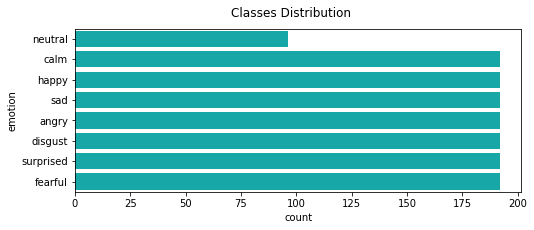

In [ ]:
### Visualize class distribution

f, ax = plt.subplots(figsize=(8, 3))
sns.countplot(y="emotion", data=df[['emotion']], color="c")
plt.suptitle('Classes Distribution');

In [ ]:
### Map files by emotion and actor
pd.crosstab(df.emotion, df.actor, margins=True, margins_name="total")

actor      Actor_01  Actor_02  Actor_03  Actor_04  Actor_05  Actor_06  \
emotion                                                                 
angry             8         8         8         8         8         8   
calm              8         8         8         8         8         8   
disgust           8         8         8         8         8         8   
fearful           8         8         8         8         8         8   
happy             8         8         8         8         8         8   
neutral           4         4         4         4         4         4   
sad               8         8         8         8         8         8   
surprised         8         8         8         8         8         8   
total            60        60        60        60        60        60   

actor      Actor_07  Actor_08  Actor_09  Actor_10  Actor_11  Actor_12  \
emotion                                                                 
angry             8         8         8         8         8         8   
calm              8         8         8         8         8         8   
disgust           8         8         8         8         8         8   
fearful           8         8         8         8         8         8   
happy             8         8         8         8         8         8   
neutral           4         4         4         4         4         4   
sad               8         8         8         8         8         8   
surprised         8         8         8         8         8         8   
total            60        60        60        60        60        60   

actor      Actor_13  Actor_14  Actor_15  Actor_16  Actor_17  Actor_18  \
emotion                                                                 
angry             8         8         8         8         8         8   
calm              8         8         8         8         8         8   
disgust           8         8         8         8         8         8   
fearful           8         8         8         8         8         8   
happy             8         8         8         8         8         8   
neutral           4         4         4         4         4         4   
sad               8         8         8         8         8         8   
surprised         8         8         8         8         8         8   
total            60        60        60        60        60        60   

actor      Actor_19  Actor_20  Actor_21  Actor_22  Actor_23  Actor_24  total  
emotion                                                                       
angry             8         8         8         8         8         8    192  
calm              8         8         8         8         8         8    192  
disgust           8         8         8         8         8         8    192  
fearful           8         8         8         8         8         8    192  
happy             8         8         8         8         8         8    192  
neutral           4         4         4         4         4         4     96  
sad               8         8         8         8         8         8    192  
surprised         8         8         8         8         8         8    192  
total            60        60        60        60        60        60   1440

In [ ]:
### Save raw dataset


file_name = 'voice_features_raw_40.csv'
df.to_csv(folder_path+file_name, index=False)

print(f'Save file: {file_name} \nInside folder: {folder_path}')

Save file: voice_features_raw_40.csv 
Inside folder: /content/drive/MyDrive/Colab Notebooks/


<br>
<a id='prep'></a>

### Vizualização

<font size=1>[menu](#menu)</font>

In [ ]:
### To load data from base file

# folder_path = '/content/drive/MyDrive/Colab Notebooks/'
# file_name = 'voice_features_raw_13.csv'
# df = pd.read_csv(folder_path + file_name)
# print(df.shape)

(1440, 181)


In [ ]:
### Remove neutral emotion tuples as recommended by ravdess publishers

# df = df[df.emotion!='neutral']
# print(df.shape)

(1344, 181)


##### Describe

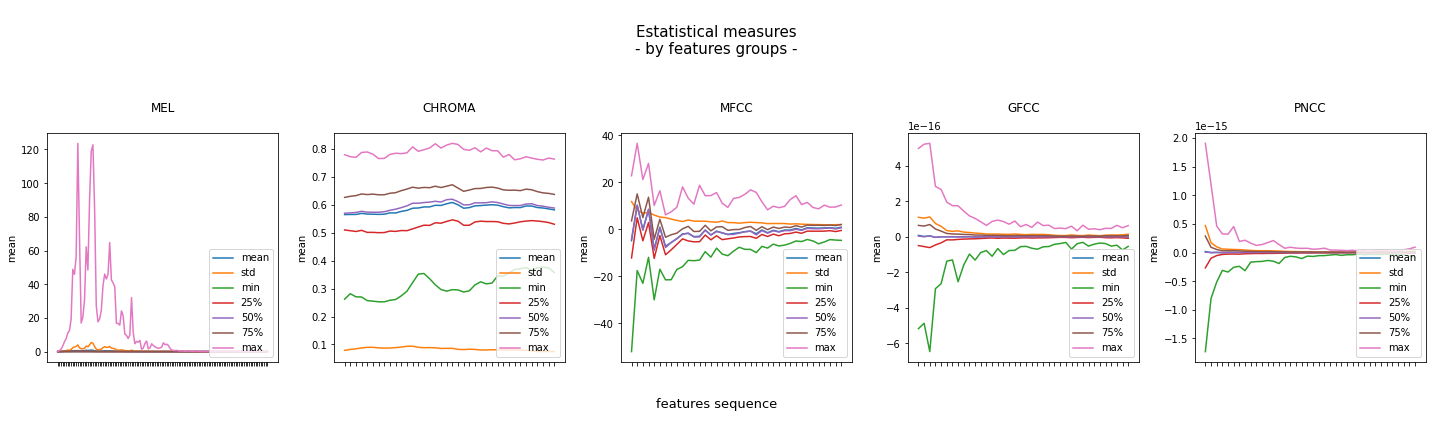

In [ ]:

rows = 1
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,6))

descr = df.describe()
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        for n in range(descr.iloc[1:,a+2:b].shape[0]):
          sns.lineplot(ax=chart, x=descr.columns[a+2:b], y=descr.iloc[n+1,a+2:b]);
          chart.legend(df.describe().index[1:],loc="lower right");
          chart.set_title(f'\n{features_name[i]}\n')
          chart.set_xticklabels([])
          # chart.set_ylabel('')
fig.supxlabel('\nfeatures sequence\n', fontsize=13)
fig.suptitle('\nEstatistical measures\n- by features groups -\n', size=15)
plt.tight_layout()

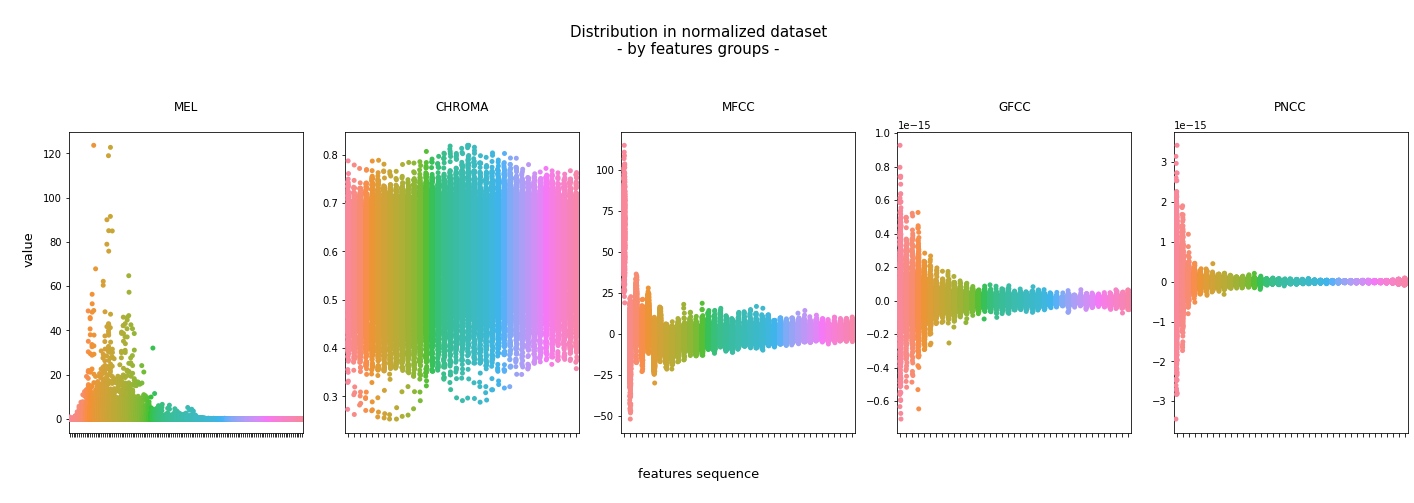

In [ ]:
rows = 1
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,7))
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        sns.stripplot(ax=chart, x='variable',y='value',data=pd.melt(df.iloc[:,a+1:b]));
        chart.set_title(f'\n{features_name[i]}\n')
        chart.set_xticklabels([])
        chart.set(xlabel=None, ylabel=None)

fig.suptitle('\nDistribution in normalized dataset\n- by features groups -\n', size=15)
fig.supxlabel('\nfeatures sequence\n', size=13)
fig.supylabel('\nvalue\n', size=13)
plt.tight_layout()

#### PCA

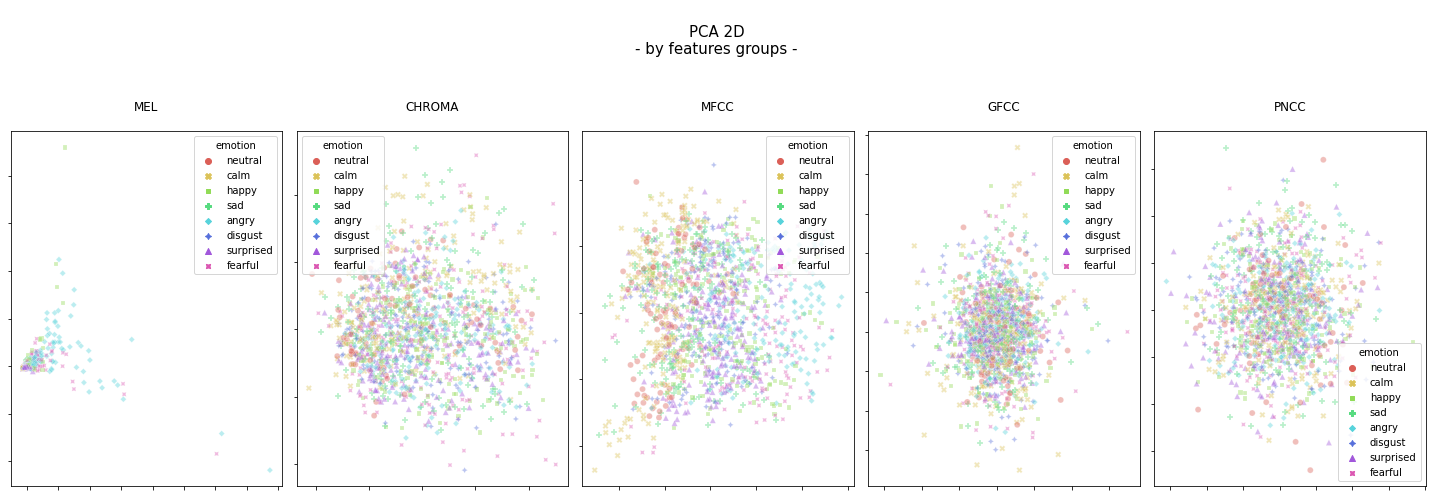

In [ ]:
from sklearn.decomposition import PCA

rows = 1
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,7))
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        pcaModel = PCA(n_components=2)
        pcaResult = pcaModel.fit_transform(df.iloc[:,a:b])
        sns.scatterplot(ax=chart,
                        x=pcaResult[:,0], y=pcaResult[:,1],
                        hue=df.emotion, style=df.emotion,
                        palette=sns.color_palette("hls", 8),
                        alpha=0.4,
                        legend="full");
        chart.set_title(f'\n{features_name[i]}\n')
        chart.set_xticklabels([])
        chart.set_yticklabels([])
        chart.set(xlabel=None, ylabel=None)

fig.suptitle('\nPCA 2D\n- by features groups -\n', size=15)
plt.tight_layout()

#### TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dis

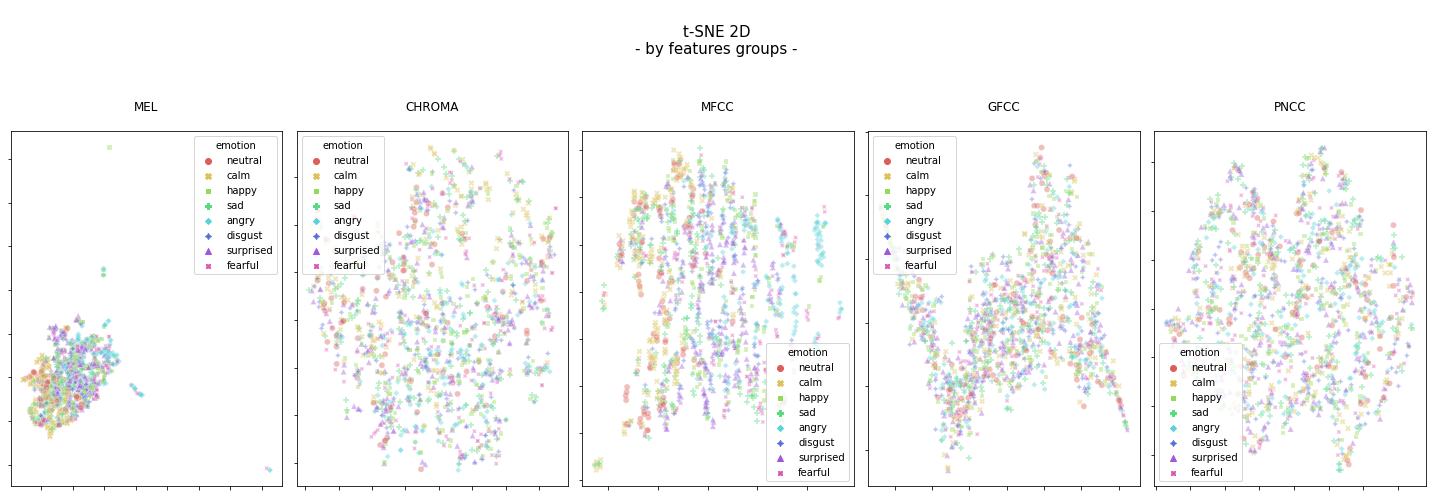

In [ ]:
from sklearn.decomposition import PCA

rows = 1
columns = 5

from sklearn.manifold import TSNE

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,7))
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        tsne = TSNE(n_components=3, perplexity=5, learning_rate='auto', init='pca',
                    n_iter=1000, n_iter_without_progress=25, verbose=0)
        tsne_results = tsne.fit_transform(df.iloc[:,a:b])
        sns.scatterplot(ax=chart,
                        x=tsne_results[:,0], y=tsne_results[:,1],
                        hue=df.emotion, style=df.emotion,
                        palette=sns.color_palette("hls", 8),
                        alpha=0.4,
                        legend="full");
        chart.set_title(f'\n{features_name[i]}\n')
        chart.set_xticklabels([])
        chart.set_yticklabels([])
        chart.set(xlabel=None, ylabel=None)

fig.suptitle('\nt-SNE 2D\n- by features groups -\n', size=15)
plt.tight_layout()


#### 3D

In [ ]:
def split_data_by_feature(data: pd.DataFrame, features_interval: list) -> dict:
    data_dict = {}
    for idx, interval in enumerate(features_interval):
      data_dict[features_name[idx]] = data.iloc[:,interval[0]:interval[1]]
    
    return data_dict

features_dict = split_data_by_feature(df, features_interval)
features_dict.keys()

dict_keys(['MEL', 'CHROMA', 'MFCC', 'GFCC', 'PNCC'])

In [ ]:

target = df.emotion.values

# X = pd.concat([features_dict['MEL'],features_dict['CHROMA'],features_dict['MFCC'],
#                  features_dict['GFCC'],features_dict['PNCC']],axis=1)
X = features_dict['MFCC']


le = LabelEncoder()
le.fit(target)
y = le.transform(target)

print(X.shape)
print(y.shape)

(1344, 13)
(1344,)


##### *PCA*

In [ ]:
from sklearn.decomposition import PCA

pcaModel = PCA(n_components=3)
pcaResult = pcaModel.fit_transform(X)

subset = pd.DataFrame()
subset['pca-1'] = pcaResult[:,0]
subset['pca-2'] = pcaResult[:,1]
subset['pca-3'] = pcaResult[:,2]

In [ ]:
pcaModel.explained_variance_.round(2)

array([10661.47,   264.45,    90.07])

In [ ]:
pca_cum = np.sum(pcaModel.explained_variance_ratio_)
print(f'Cumulative explained variation for 3 principal components: {round(pca_cum,2)}')

Cumulative explained variation for 3 principal components: 0.99


In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=subset['pca-1'], y=subset['pca-2'], z=subset['pca-3'],
                    color=target, opacity=0.7)
fig.update_traces(marker_size=5)
fig.update_layout(height=600, width=1200,
                  title='PCA 3D')
fig.show()

##### *TSNE*

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
subset['tsne-1'] = tsne_results[:,0]
subset['tsne-2'] = tsne_results[:,1]
subset['tsne-3'] = tsne_results[:,2]

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=subset['tsne-1'],                   
                    y=subset['tsne-2'],
                    z=subset['tsne-3'],
                    symbol=target,
                    color=target, opacity=0.7)
fig.update_traces(marker_size=4)
fig.update_layout(height=650, width=900,
                  title='t-SNE / PCA',
                  legend_title_text='Emotion')
fig.show()

##### *PCA-TSNE*

In [ ]:
tsne = TSNE(n_components=3, verbose=1)
tsne_pca_results = tsne.fit_transform(pcaResult)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1344 samples in 0.002s...
[t-SNE] Computed neighbors for 1344 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1344
[t-SNE] Computed conditional probabilities for sample 1344 / 1344
[t-SNE] Mean sigma: 9.339484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.587017
[t-SNE] KL divergence after 1000 iterations: 0.467789


In [ ]:
subset['tsne-pca-1'] = tsne_pca_results[:,0]
subset['tsne-pca-2'] = tsne_pca_results[:,1]
subset['tsne-pca-3'] = tsne_pca_results[:,2]


In [ ]:
fig = px.scatter_3d(x=subset['tsne-pca-1'],                   
                    y=subset['tsne-pca-2'],
                    z=subset['tsne-pca-3'],
                    symbol=target,
                    color=target, opacity=0.5,
                    # color_discrete_sequence=px.colors.qualitative.T10
                  )
fig.update_traces(marker_size=4)
fig.update_layout(height=650, width=1000,
                  title='t-SNE / PCA',
                  legend_title_text='Emotion')
fig.show()

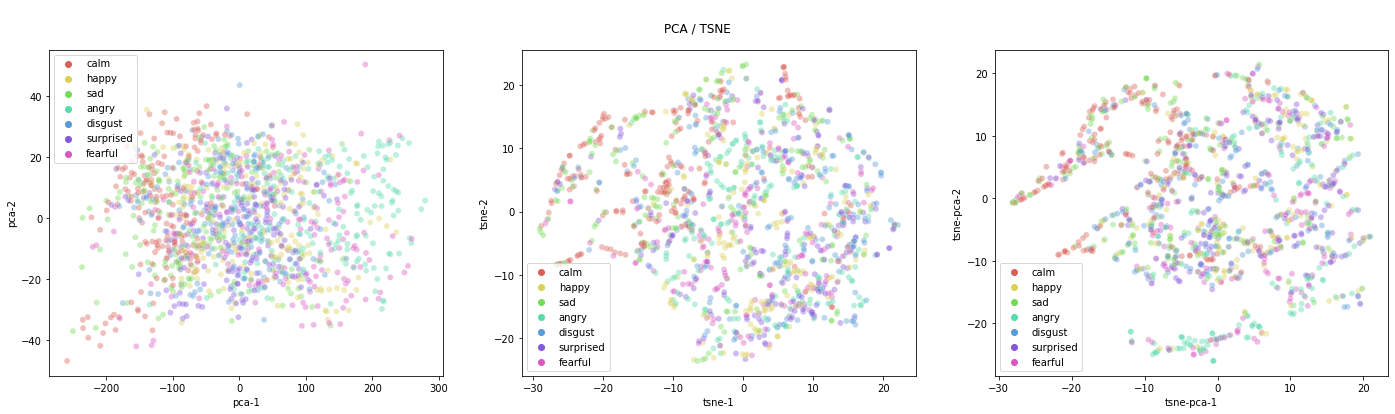

In [ ]:

plt.figure(figsize=(24,6))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue=target,
    palette=sns.color_palette("hls", 7),
    data=subset,
    legend="full",
    alpha=0.4,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue=target,
    palette=sns.color_palette("hls", 7),
    data=subset,
    legend="full",
    alpha=0.4,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca-1", y="tsne-pca-2",
    hue=target,
    palette=sns.color_palette("hls", 7),
    data=subset,
    legend="full",
    alpha=0.4,
    ax=ax3
)
plt.suptitle('\nPCA / TSNE\n', size=12);

<h4>Normalize data</h4>

In [ ]:
## Load dataset
# df = pd.read_csv('../data/voice_features_raw.csv')
file_name = 'voice_features_raw.csv'
df = pd.read_csv(folder_path + file_name)
print(df.shape)
df.head(2)

(1440, 262)


0         1         2         3         4         5         6  \
0  0.000017  0.001432  0.016623  0.026257  0.015734  0.010567  0.021449   
1  0.000013  0.000555  0.009175  0.020292  0.018322  0.006961  0.013214   

          7         8         9       10        11        12        13  \
0  0.021755  0.020524  0.009863  0.00822  0.013816  0.033411  0.040123   
1  0.015581  0.016653  0.013299  0.00488  0.005009  0.009620  0.019270   

         14        15        16        17        18        19        20  \
0  0.012572  0.013553  0.034026  0.013780  0.002775  0.009250  0.014812   
1  0.014089  0.002810  0.002958  0.008433  0.005448  0.000935  0.001446   

         21        22        23        24        25        26        27  \
0  0.005438  0.000991  0.000789  0.000499  0.000236  0.000204  0.000422   
1  0.004113  0.002633  0.000371  0.000264  0.000293  0.000107  0.000083   

         28        29        30        31        32        33        34  \
0  0.000827  0.000662  0.000440  0.000311  0.001147  0.001432  0.001616   
1  0.000176  0.000178  0.000349  0.000179  0.000137  0.000242  0.000957   

         35        36        37        38        39        40        41  \
0  0.003586  0.003505  0.000857  0.000492  0.000760  0.000564  0.000585   
1  0.001207  0.000271  0.000193  0.000659  0.000289  0.000185  0.000401   

         42        43        44        45        46        47        48  \
0  0.000884  0.000715  0.000982  0.000890  0.000628  0.000447  0.000292   
1  0.000114  0.000638  0.000640  0.000149  0.000215  0.000227  0.000187   

         49        50        51        52        53        54        55  \
0  0.000514  0.001107  0.000223  0.000068  0.000124  0.000108  0.000124   
1  0.000705  0.000376  0.000076  0.000070  0.000059  0.000077  0.000101   

         56        57        58        59        60        61        62  \
0  0.000363  0.000613  0.000627  0.000435  0.000205  0.000093  0.000101   
1  0.000134  0.000137  0.000316  0.000212  0.000143  0.000063  0.000042   

         63        64        65        66        67        68        69  \
0  0.000087  0.000127  0.000178  0.000218  0.000291  0.000348  0.000403   
1  0.000015  0.000012  0.000015  0.000024  0.000035  0.000052  0.000077   

         70        71        72        73        74        75        76  \
0  0.000125  0.000042  0.000013  0.000016  0.000023  0.000040  0.000047   
1  0.000076  0.000046  0.000012  0.000006  0.000010  0.000015  0.000023   

         77       78        79        80        81        82        83  \
0  0.000064  0.00008  0.000052  0.000048  0.000026  0.000025  0.000037   
1  0.000018  0.00004  0.000034  0.000025  0.000028  0.000033  0.000050   

         84        85        86        87        88        89        90  \
0  0.000028  0.000018  0.000012  0.000008  0.000005  0.000004  0.000004   
1  0.000050  0.000039  0.000034  0.000015  0.000007  0.000006  0.000006   

         91        92        93        94        95        96        97  \
0  0.000005  0.000006  0.000004  0.000002  0.000003  0.000003  0.000003   
1  0.000006  0.000005  0.000007  0.000005  0.000003  0.000004  0.000004   

         98        99       100       101       102       103       104  \
0  0.000002  0.000002  0.000004  0.000006  0.000006  0.000005  0.000004   
1  0.000005  0.000006  0.000003  0.000004  0.000004  0.000004  0.000003   

        105       106       107       108       109       110       111  \
0  0.000003  0.000003  0.000002  0.000002  0.000002  0.000002  0.000001   
1  0.000004  0.000004  0.000002  0.000002  0.000002  0.000001  0.000001   

            112           113           114           115           116  \
0  1.236189e-06  2.178529e-06  1.341962e-06  8.759328e-07  7.719471e-07   
1  8.758655e-07  7.264676e-07  4.894324e-07  3.679957e-07  2.989512e-07   

            117           118           119           120           121  \
0  5.428048e-07  3.798515e-07  2.659118e-07  1.358990e-07  6.421450e-08   
1  1.622806e-07  1.37643

In [ ]:
features_group = []
for i, interval in enumerate(features_interval):
    a,b = interval
    features_group.append(df.iloc[:,a:b])

In [ ]:
### Normalize features by group type

emotions = df.loc[:,'emotion']
df = pd.DataFrame()

for i, grp in enumerate(features_group):
    scaler  =  StandardScaler()  ### MinMaxScaler()
    normalized = scaler.fit_transform(grp.values)
    df = pd.concat([df, pd.DataFrame(normalized)], axis=1)

df = pd.concat([df,emotions],axis=1)


In [ ]:
### Normalize features (all together)

# emotions = df.loc[:,'emotion']
# df.drop(columns=['emotion','actor'], inplace=True)

# scaler  =  MinMaxScaler()
# normalized = scaler.fit_transform(df.values)

# df = pd.concat([pd.DataFrame(normalized),emotions],axis=1)


In [ ]:
### Save normalized dataset with labels
# file_name = 'voice_features_normalized.csv'
# df.to_csv(folder_path + file_name, index=False)
# print(f'Save file: {file_name} \nInside folder: {folder_path}')

In [ ]:
# ### To save datasets splited by feature type

# for idx, interval in enumerate(features_interval):
#   aux = df.iloc[:,interval[0]:interval[1]]
#   aux.columns = [features_name[idx]+'_'+str(i) for i in range(interval[1]-interval[0])]
#   aux['emotion'] = df.loc[:,'emotion']
#   # Save raw dataset
#   file_name = f'voice_features_normalized_{features_name[idx]}.csv'
#   # df.to_csv('../data/voice_features_raw.csv', index=False)
#   aux.to_csv(folder_path+file_name, index=False)
#   print(f'Save file: {file_name} \nInside folder: {folder_path}')

<h4>Target encoder</h4>

In [ ]:
# ### Encode emotions

# y = emotions.values

# lb = LabelEncoder()
# Y = lb.fit_transform(y)
# Y = to_categorical(Y)

# print(y.shape)
# print(y[:3])

# print()
# print(Y.shape)
# print(Y[:3])

In [ ]:
# # Create dataset with encoded target
# df = pd.concat([df.iloc[:,:-1], pd.DataFrame(Y, columns=lb.classes_)], axis=1)
# print(df.shape)
# df.head(3)

In [ ]:
# # Save normalized and encoded dataset
# file_name = 'voice_features_normalized_encoded.csv'
# # df.to_csv('../data/voice_features_normalized_encoded.csv', index=False)
# df.to_csv(folder_path + file_name, index=False)
# print(f'Save file: {file_name} \nInside folder: {folder_path}')


<hr>

#### Visualização dos dados Normalizados

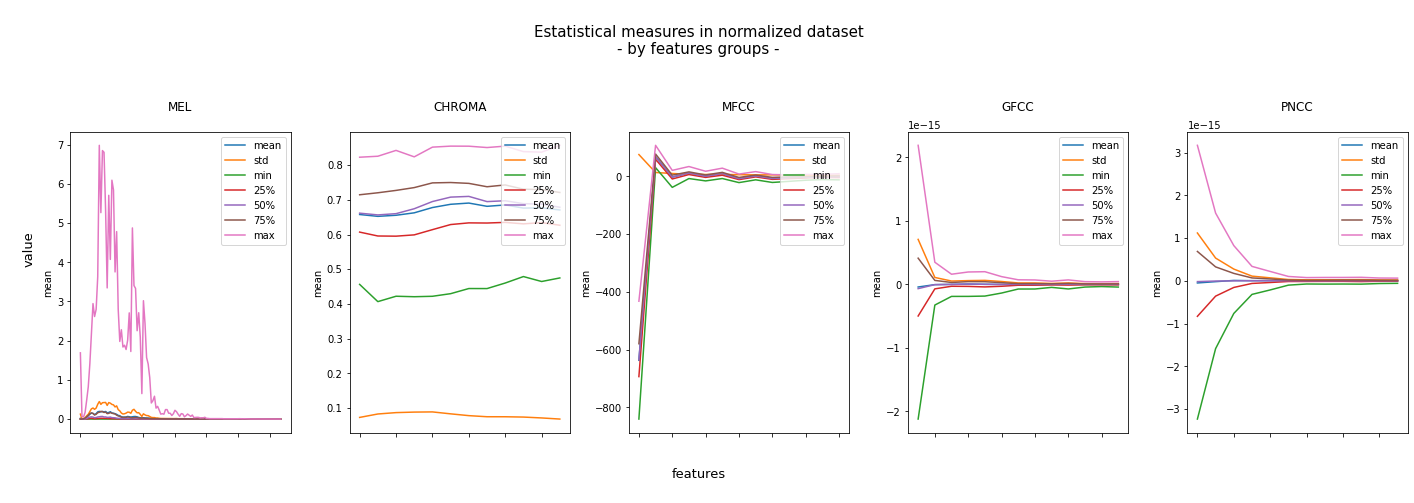

In [ ]:

rows = 1
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,7))

descr = df.describe()
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        for n in range(descr.iloc[1:,a:b].shape[0]):
          sns.lineplot(ax=chart, x=descr.columns[a:b], y=descr.iloc[n+1,a:b]);
          chart.legend(df.describe().index[1:],loc="upper right");
          chart.set_xticklabels([])
          chart.set_title(f'\n{features_name[i]}\n')

fig.supxlabel('\nfeatures\n', size=13)
fig.supylabel('\nvalue\n', size=13)
fig.suptitle('\nEstatistical measures in normalized dataset\n- by features groups -\n', size=15)
plt.tight_layout()

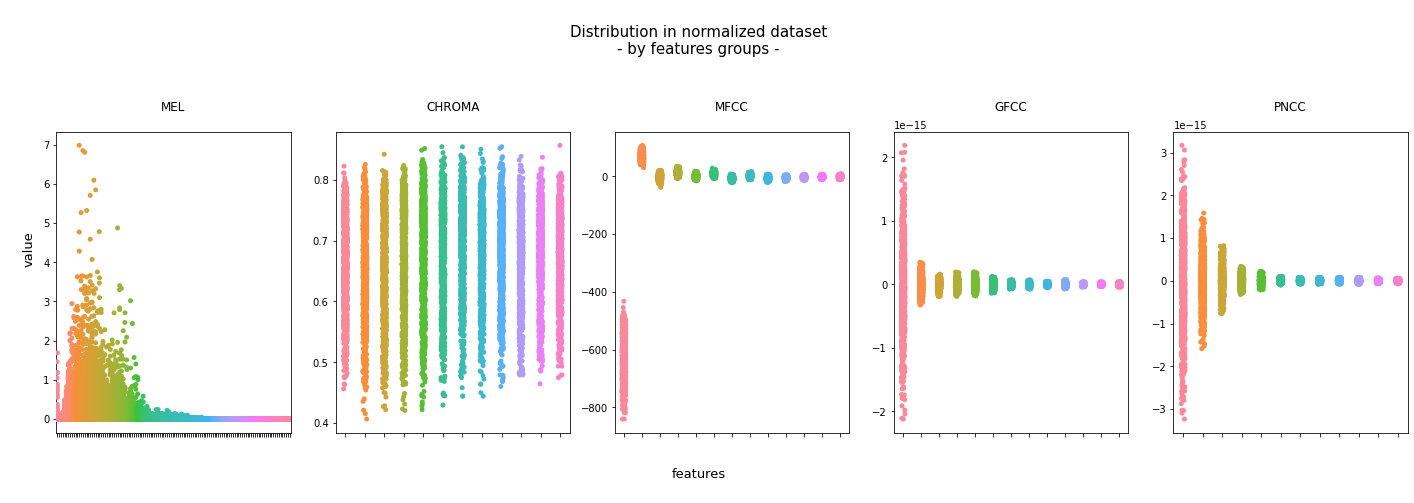

In [ ]:
rows = 1
columns = 5

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,7))
for i, chart in enumerate(ax):
        a,b = features_interval[i]
        sns.stripplot(ax=chart, x='variable',y='value',data=pd.melt(df.iloc[:,a:b]));
        chart.set_title(f'\n{features_name[i]}\n')
        chart.set_xticklabels([])
        chart.set(xlabel=None, ylabel=None)

fig.suptitle('\nDistribution in normalized dataset\n- by features groups -\n', size=15)
fig.supxlabel('\nfeatures\n', size=13)
fig.supylabel('\nvalue\n', size=13)
plt.tight_layout()

In [ ]:
def plot_feature_dist(df: pd.DataFrame, feature:str):

    emotions_list = ['angry', 'fearful', 'disgust', 'sad', 'surprised', 'happy', 'calm', 'neutral']
    features_interval_dict = {
        'MEL': features_interval[0],
        'CHROMA': features_interval[1],
        'MFCC': features_interval[2],
        'GFCC': features_interval[3],
        'PNCC': features_interval[4],
        
    }

    rows = 4
    columns = 2

    fig, ax = plt.subplots(nrows=rows, ncols=columns,  sharex=True, sharey=True, figsize=(20,15))
    ax = ax.ravel()

    for i,em in enumerate(emotions_list):
        a,b = features_interval_dict[feature]
        mask = (df.emotion==em)
        data = df[mask].iloc[:,a:b]
        for idx, row in data.iterrows():
          ax[i].plot(row, alpha=.75)
       
        data_mean = data.mean()
        data_std = data.std()
        ax[i].plot(data_mean, linewidth=2, color='indigo', ls='--')
        ax[i].fill_between(range(len(data_mean)),
                           data_mean+data_std,data_mean-data_std,
                           color='silver', alpha=.8)
        ax[i].set_xticklabels([])
        ax[i].set_title(f'\n{em.upper()}')

    fig.suptitle(f'\n{feature.upper()}\nfeatures distribution\n- by emotion - ', fontsize=20)
    fig.supxlabel('\n features\n', fontsize=18)
    fig.supylabel('\nvalues \n', fontsize=18)
    fig.tight_layout()
    plt.tight_layout()

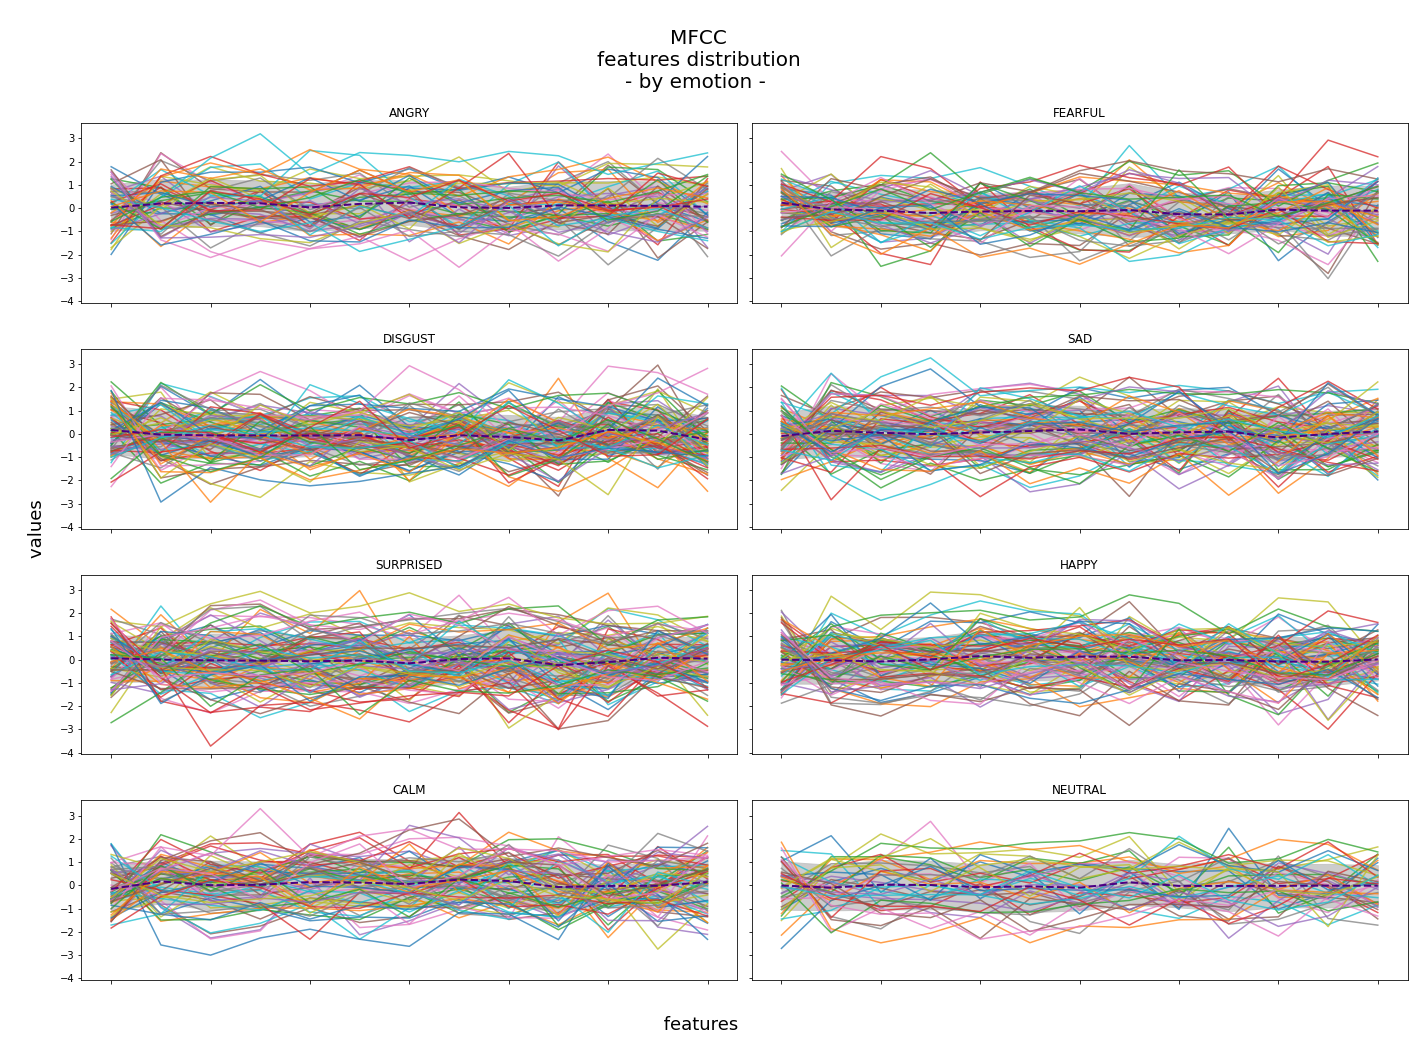

In [ ]:
plot_feature_dist(df, 'MFCC')

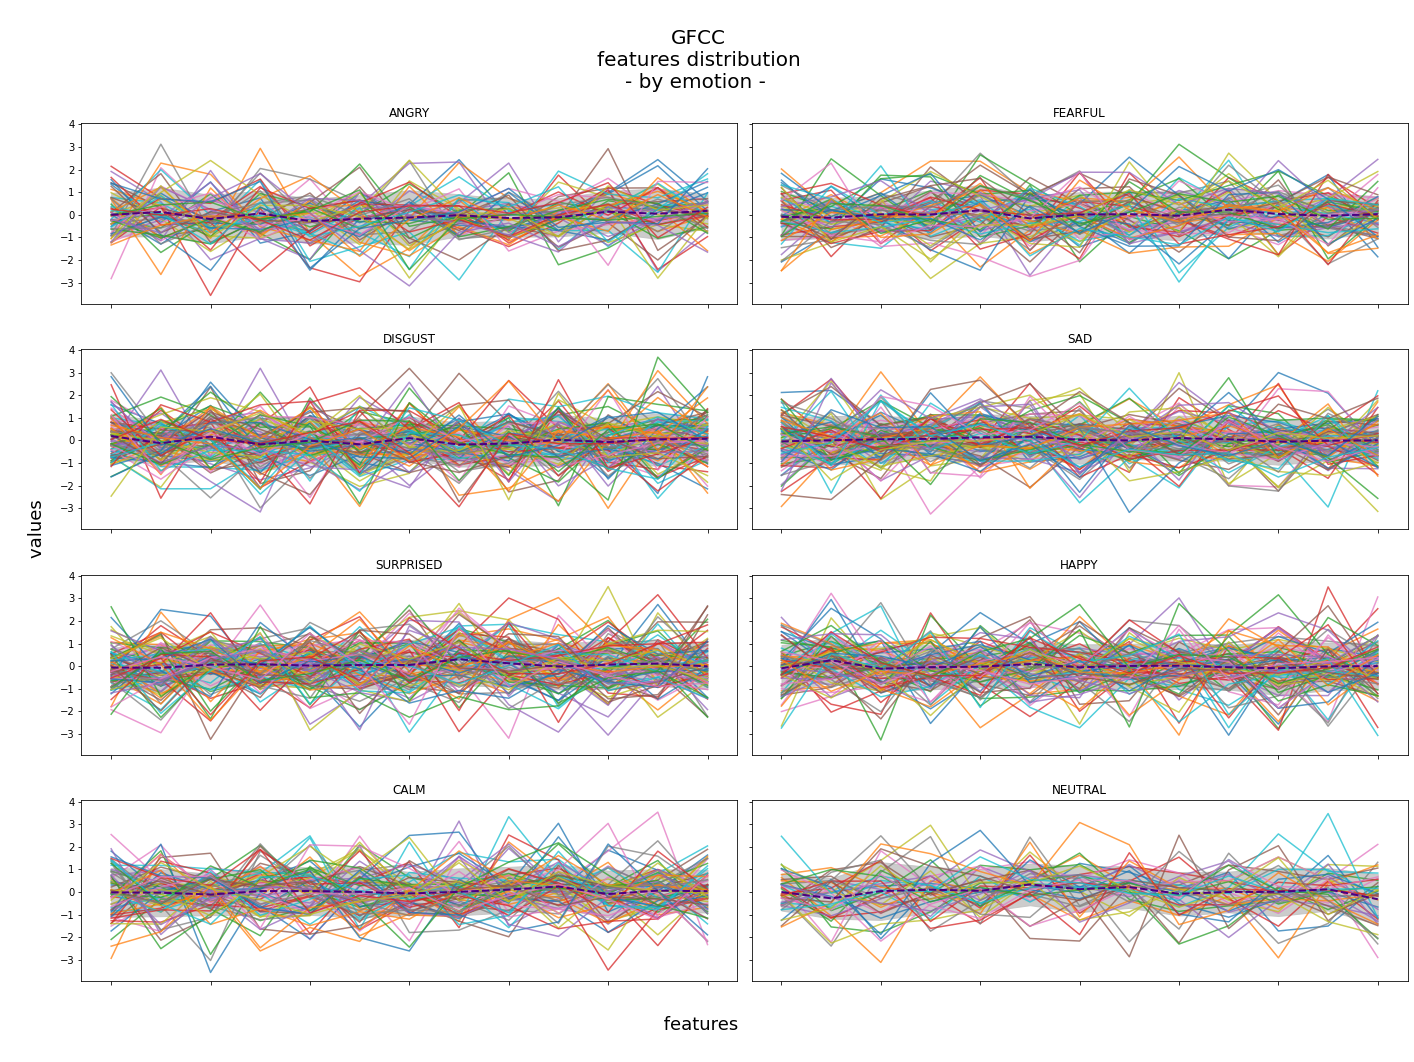

In [ ]:
plot_feature_dist(df,'GFCC')

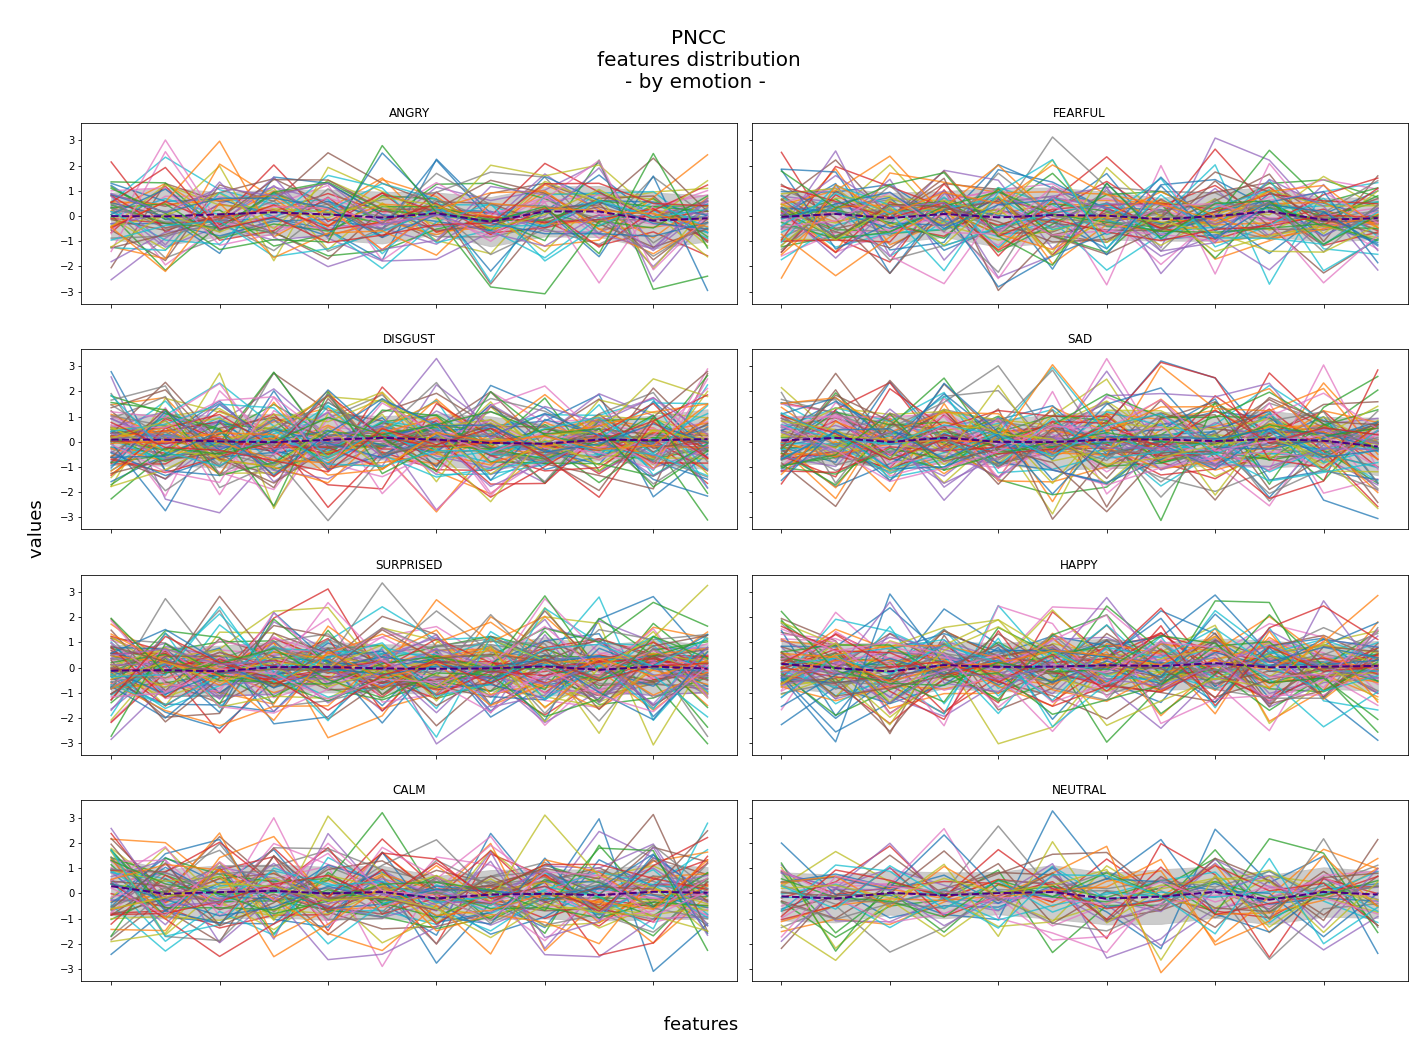

In [ ]:
plot_feature_dist(df,'PNCC')

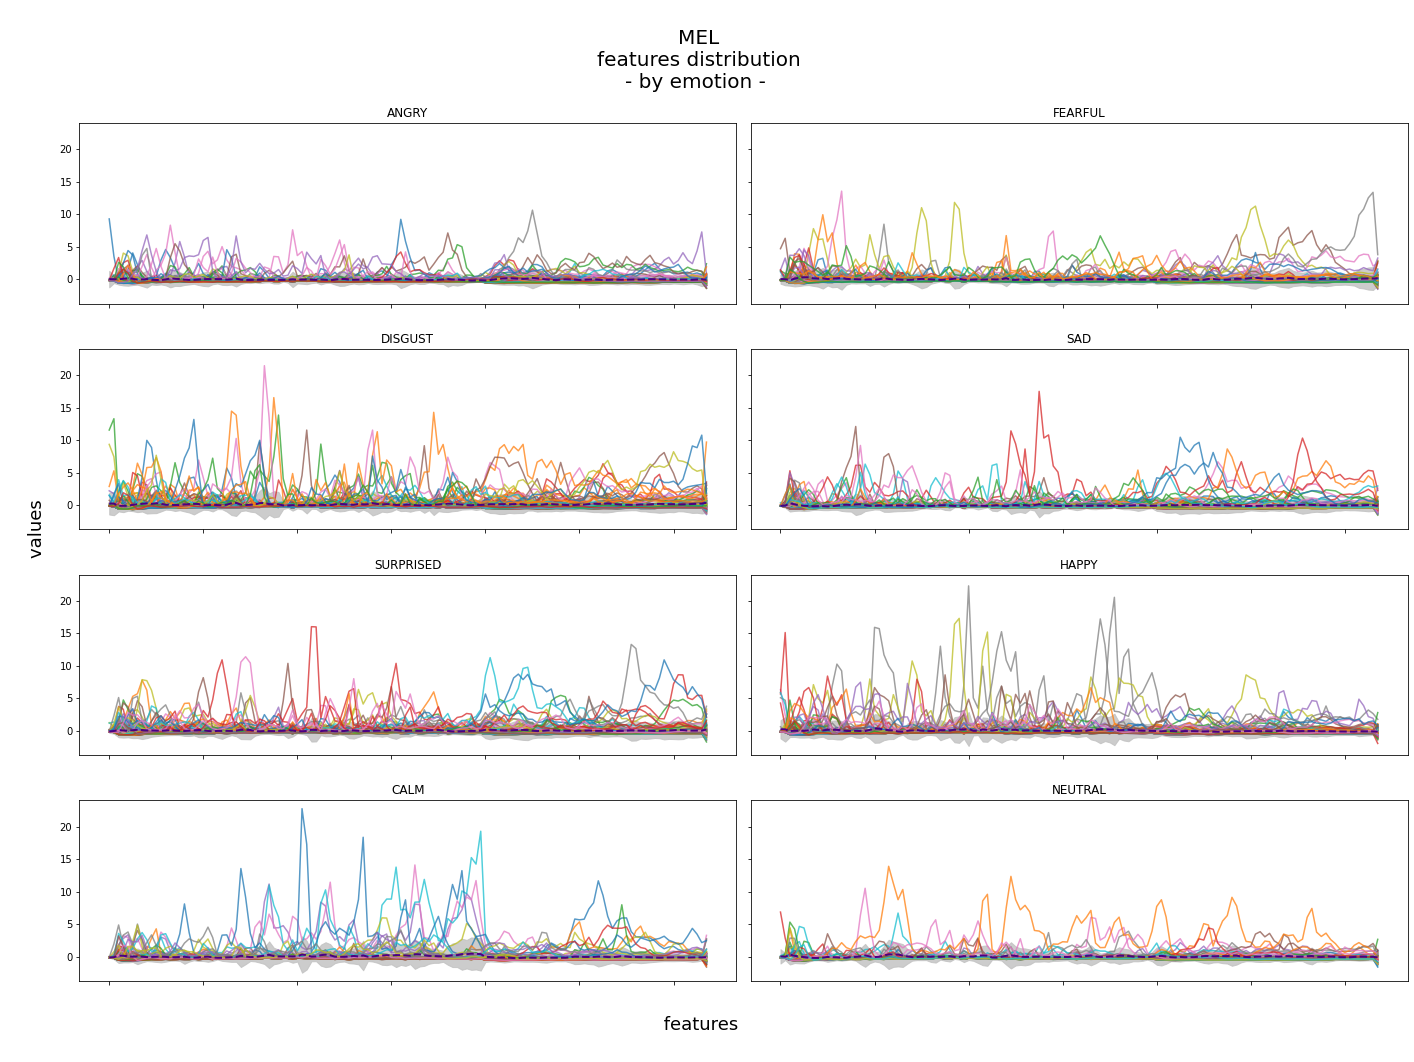

In [ ]:
plot_feature_dist(df,'MEL')

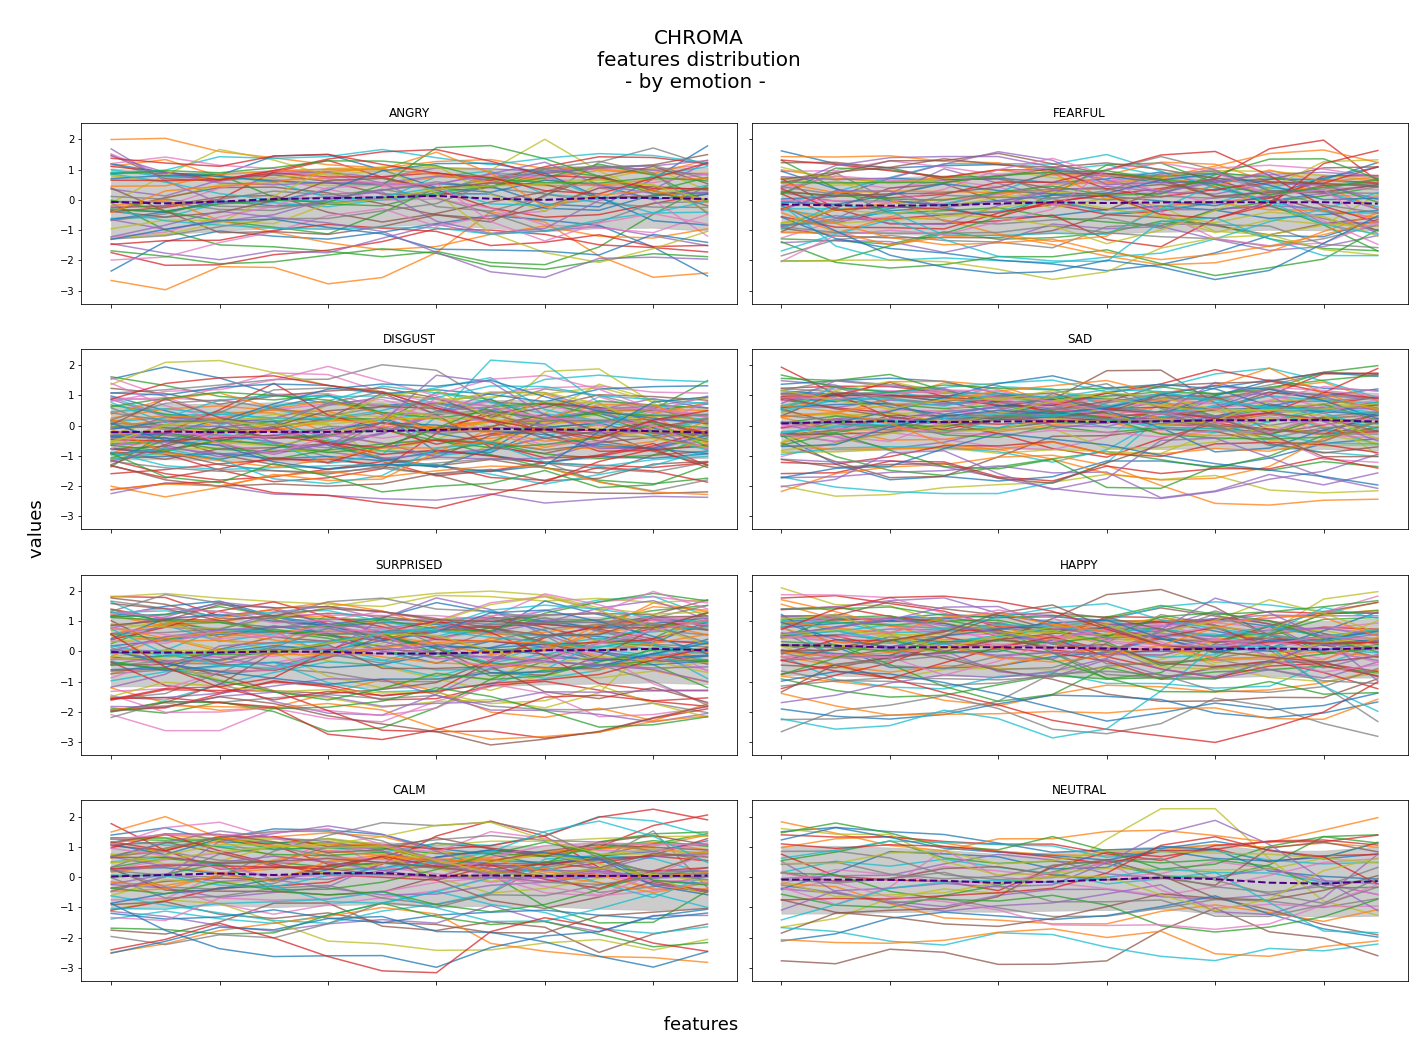

In [ ]:
plot_feature_dist(df,'CHROMA')

<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>